In [1]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
#import soundfile as sf
import os
import glob
import numpy as np
from PIL import Image
from scipy.fftpack import fft
from scipy.misc import imresize
from IPython.display import Image
import mobilenet_model as mobilenet_v1
from IPython.core.display import HTML
from tensorflow.contrib.framework.python.ops import arg_scope
import numpy as np
import pandas as pd
from sklearn import metrics
from absl import flags
import tensorflow as tf
import operator
from PIL import Image
import seaborn as sns
import cv2
import random
import tensorflow_hub as hub
from tensorflow.python.data import Dataset
%matplotlib inline
# tf.logging.set_verbosity(tf.logging.INFO)
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
test_pict_path = './input/picts/test/'

In [3]:
labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go']

test_labels = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']

label_dict = {'yes':0, 'no':1, 'up':2, 'down':3, 'left':4,
                  'right':5, 'on':6, 'off':7, 'stop':8, 'go':9, 'silence':10, 'unknown':11}

In [4]:
flags.DEFINE_string(
    'tpu', default=None,
    help='The Cloud TPU to use for training. This should be either the name '
    'used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.')
flags.DEFINE_string(
    'gcp_project', default=None,
    help='Project name for the Cloud TPU-enabled project. If not specified, we '
    'will attempt to automatically detect the GCE project from metadata.')
flags.DEFINE_string(
    'tpu_zone', default=None,
    help='GCE zone where the Cloud TPU is located in. If not specified, we '
    'will attempt to automatically detect the GCE project from metadata.')

# Model specific paramenters
flags.DEFINE_string(
    'data_dir', '',
    'Directory where input data is stored')

flags.DEFINE_string(
    'model_dir', None,
    'Directory where model output is stored')

flags.DEFINE_integer(
    'num_shards', 8,
    'Number of shards (workers).')

flags.DEFINE_integer(
    'iterations', 100,
    'Number of iterations per TPU training loop.')

flags.DEFINE_integer(
    'train_batch_size', 1024,
    'Global (not per-shard) batch size for training')

flags.DEFINE_integer(
    'eval_total_size', 0,
    'Total batch size for evaluation, use the entire validation set if 0')

flags.DEFINE_integer(
    'eval_batch_size', 1024,
    'Global (not per-shard) batch size for evaluation')

flags.DEFINE_integer(
    'train_steps', 8000000,
    'Number of steps use for training.')

flags.DEFINE_integer(
    'train_steps_per_eval', 2000,
    'Number of training steps to run between evaluations.')

flags.DEFINE_string(
    'mode', 'train_and_eval',
    'Mode to run: train, eval, train_and_eval')

flags.DEFINE_integer(
    'min_eval_interval', 180,
    'Minimum number of seconds between evaluations')

flags.DEFINE_integer(
    'eval_timeout', None,
    'Evaluation timeout: Maximum number of seconds that '
    'may elapse while no new checkpoints are observed')

flags.DEFINE_bool(
    'use_tpu', True,
    'Use TPUs rather than plain CPUs')

flags.DEFINE_boolean(
    'per_host_input_for_training', True,
    'If true, input_fn is invoked per host rather than per shard.')

flags.DEFINE_string(
    'use_data', 'real',
    'One of "fake","real"')

flags.DEFINE_float(
    'learning_rate', 0.165,
    'Learning rate.')

flags.DEFINE_float(
    'depth_multiplier', 1.0,
    'Depth Multiplier on Inception')

flags.DEFINE_string(
    'optimizer', 'RMS',
    'Optimizer (one of sgd, RMS, momentum)')

flags.DEFINE_integer(
    'num_classes', 1001,
    'Number of classes to distinguish')

flags.DEFINE_integer(
    'width', 96,
    'Width of input image')

flags.DEFINE_integer(
    'height', 96,
    'Height of input image')

flags.DEFINE_bool(
    'transpose_enabled', False,
    'Boolean to enable/disable explicit I/O transpose')

flags.DEFINE_bool(
    'use_fused_batchnorm', True,
    'Enable fused batchrnom')

flags.DEFINE_bool(
    'log_device_placement', False,
    'Boolean to enable/disable log device placement')

flags.DEFINE_integer(
    'save_summary_steps', 100,
    'Number of steps which must have run before showing summaries.')

flags.DEFINE_integer(
    'save_checkpoints_secs', 1000,
    'Interval (in seconds) at which the model data '
    'should be checkpointed. Set to 0 to disable.')

flags.DEFINE_bool(
    'moving_average', True,
    'Whether to enable moving average computation on variables')

flags.DEFINE_string(
    'preprocessing', 'inception',
    'Preprocessing stage to use: one of inception or vgg')

flags.DEFINE_bool(
    'use_annotated_bbox', False,
    'If true, use annotated bounding box as input to cropping function, '
    'else use full image size')

flags.DEFINE_float(
    'learning_rate_decay', 0.94,
    'Exponential decay rate used in learning rate adjustment')

flags.DEFINE_integer(
    'learning_rate_decay_epochs', 3,
    'Exponential decay epochs used in learning rate adjustment')

flags.DEFINE_bool(
    'use_logits', True,
    'Use logits if true, else use predictions')

flags.DEFINE_bool(
    'display_tensors', False,
    'Whether to dump prediction tensors for comparison')

flags.DEFINE_bool(
    'clear_update_collections', True,
    'Set batchnorm update_collections to None if true, else use default value')

# Dataset specific paramenters
flags.DEFINE_bool(
    'prefetch_enabled', True,
    'Boolean to enable/disable prefetching')

flags.DEFINE_integer(
    'prefetch_dataset_buffer_size', 8*1024*1024,
    'Number of bytes in read buffer. 0 means no buffering.')

flags.DEFINE_integer(
    'num_files_infeed', 8,
    'Number of training files to read in parallel.')

flags.DEFINE_integer(
    'num_parallel_calls', 64,
    'Number of elements to process in parallel (by mapper)')

flags.DEFINE_integer(
    'initial_shuffle_buffer_size', 1024,
    'Number of elements from dataset that shuffler will sample from. '
    'This shuffling is done before any other operations. '
    'Set to 0 to disable')

flags.DEFINE_integer(
    'followup_shuffle_buffer_size', 1000,
    'Number of elements from dataset that shuffler will sample from. '
    'This shuffling is done after prefetching is done. '
    'Set to 0 to disable')


FLAGS = flags.FLAGS

In [5]:
def input_fn(self, params):
    """Input function which provides a single batch for train or eval.
    Args:
      params: `dict` of parameters passed from the `TPUEstimator`.
          `params['batch_size']` is always provided and should be used as the
          effective batch size.
    Returns:
      A (images, labels) tuple of `Tensor`s for a batch of samples.
    """
    batch_size = params['batch_size']

    if FLAGS.use_data == 'real':
      file_pattern = os.path.join(
          self.data_dir, 'train-*' if self.is_training else 'validation-*')
      dataset = tf.data.Dataset.list_files(file_pattern,
                                           shuffle=self.is_training)

      if self.is_training:
        dataset = dataset.repeat()

      def prefetch_dataset(filename):
        dataset = tf.data.TFRecordDataset(
            filename, buffer_size=FLAGS.prefetch_dataset_buffer_size)
        return dataset

      dataset = dataset.apply(
          tf.contrib.data.parallel_interleave(
              prefetch_dataset,
              cycle_length=FLAGS.num_files_infeed,
              sloppy=True))

      if FLAGS.followup_shuffle_buffer_size > 0:
        dataset = dataset.shuffle(
            buffer_size=FLAGS.followup_shuffle_buffer_size)

      dataset = dataset.map(
          self.dataset_parser,
          num_parallel_calls=FLAGS.num_parallel_calls)

      dataset = dataset.prefetch(batch_size)

      dataset = dataset.apply(
          tf.contrib.data.batch_and_drop_remainder(batch_size))

      dataset = dataset.prefetch(2)  # Prefetch overlaps in-feed with training

      images, labels = dataset.make_one_shot_iterator().get_next()
      images.set_shape([batch_size, FLAGS.height, FLAGS.width, 3])
    else:
      images = tf.random_uniform(
          [batch_size, FLAGS.height, FLAGS.width, 3], minval=-1, maxval=1)
      labels = tf.random_uniform(
          [batch_size], minval=0, maxval=999, dtype=tf.int32)

    images = tensor_transform_fn(images, params['output_perm'])
    return images, labels

In [6]:
!rm -rf model_output
!gsutil cp -r gs://hurrylearn/yes_no_data/model_output . 

Copying gs://hurrylearn/yes_no_data/model_output/checkpoint...
Copying gs://hurrylearn/yes_no_data/model_output/events.out.tfevents.1531946172.rainbowww5...
Copying gs://hurrylearn/yes_no_data/model_output/events.out.tfevents.1531949416.rainbowww5...
\ [3 files][ 30.7 MiB/ 30.7 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m -o ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://hurrylearn/yes_no_data/model_output/events.out.tfevents.1531950557.rainbowww5...
Copying gs://hurrylearn/yes_no_data/model_output/events.out.tfevents.1531952727.rainbowww5...
Copying gs://hurrylearn/yes_no_data/model_output/graph.pbtxt...                 
Copying gs://hurrylearn/yes_no_data/model_output/model.ckpt-0.data-00000-of-00001...
Copying gs://hurrylearn/yes_no_data/model_output/model.ckpt-0.

In [7]:
latest_checkpoint = tf.train.latest_checkpoint('./model_output')
print(latest_checkpoint)

./model_output/model.ckpt-8000


In [8]:
meta_path = latest_checkpoint + '.meta'
print(meta_path)

./model_output/model.ckpt-8000.meta


In [9]:
# with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph(meta_path)
#     new_saver.restore(sess, latest_checkpoint)
#     all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#     for x in all_vars:
#         x_ = sess.run(x)
#         print("weights for %s" % x_)

In [55]:
test_images = []
fnames = []
all_files = [y for y in os.listdir(test_pict_path) if '.jpg' in y]
random.shuffle(all_files)
print(type(all_files))
for file in all_files[:40]:
    test_images.append(cv2.imread(test_pict_path + file))
    fnames.append(file[:-4] + '.wav')
test_images = np.array(test_images, dtype="float32")
# test_images /= (255 / 2)
# test_images -= 1
print(test_images)

<class 'list'>
[[[[ 141.  141.  141.]
   [  96.   96.   96.]
   [  93.   93.   93.]
   ..., 
   [ 218.  218.  218.]
   [ 220.  220.  220.]
   [ 226.  226.  226.]]

  [[ 128.  128.  128.]
   [ 100.  100.  100.]
   [ 100.  100.  100.]
   ..., 
   [ 232.  232.  232.]
   [ 236.  236.  236.]
   [ 239.  239.  239.]]

  [[ 159.  159.  159.]
   [ 123.  123.  123.]
   [ 113.  113.  113.]
   ..., 
   [ 231.  231.  231.]
   [ 224.  224.  224.]
   [ 230.  230.  230.]]

  ..., 
  [[ 137.  137.  137.]
   [  95.   95.   95.]
   [  97.   97.   97.]
   ..., 
   [ 207.  207.  207.]
   [ 224.  224.  224.]
   [ 240.  240.  240.]]

  [[ 137.  137.  137.]
   [ 108.  108.  108.]
   [ 112.  112.  112.]
   ..., 
   [ 227.  227.  227.]
   [ 235.  235.  235.]
   [ 255.  255.  255.]]

  [[ 136.  136.  136.]
   [ 108.  108.  108.]
   [ 107.  107.  107.]
   ..., 
   [ 220.  220.  220.]
   [ 226.  226.  226.]
   [ 231.  231.  231.]]]


 [[[ 183.  183.  183.]
   [ 127.  127.  127.]
   [ 127.  127.  127.]
   ..., 
   

In [37]:
# test_images = []
# fnames = []
# all_files = [y for y in os.listdir(test_pict_path) if '.jpg' in y]
# random.shuffle(all_files)
# print(type(all_files))
# for file in all_files[:40]:
#     test_images.append(cv2.imread(test_pict_path + file))
#     fnames.append(file[:-4] + '.wav')
# test_images = np.array(test_images, dtype="float32")
# test_images /= (255 / 2)
# test_images -= 1
# print(test_images)

In [38]:
def tensor_transform_fn(data, perm):
  """Transpose function.

  This function is used to transpose an image tensor on the host and then
  perform an inverse transpose on the TPU. The transpose on the TPU gets
  effectively elided thus voiding any associated computational cost.

  NOTE: Eventually the compiler will be able to detect when this kind of
  operation may prove beneficial and perform these types of transformations
  implicitly, voiding the need for user intervention

  Args:
    data: Tensor to be transposed
    perm: Permutation of the dimensions of a

  Returns:
    Transposed tensor
  """
  if False:
    return tf.transpose(data, perm)
  return data

In [39]:
def model_fn(features, labels, mode, params):
    num_classes = 1001
    training_active = (mode == tf.estimator.ModeKeys.TRAIN)
    eval_active = (mode == tf.estimator.ModeKeys.EVAL)
    features = tensor_transform_fn(features, params['input_perm'])

    if 1 == 1:
    # updates_collections must be set to None in order to use fused batchnorm
        with arg_scope(mobilenet_v1.mobilenet_v1_arg_scope()):
            logits, end_points = mobilenet_v1.mobilenet_v1(
              features,
              num_classes,
              is_training=training_active,
              depth_multiplier=1.0)
    else:
        with arg_scope(mobilenet_v1.mobilenet_v1_arg_scope()):
          logits, end_points = mobilenet_v1.mobilenet_v1(
              features,
              num_classes,
              is_training=training_active,
              depth_multiplier=1.0)

    predictions = {
      'classes': tf.argmax(input=logits, axis=1),
      'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

In [40]:
def construct_feature_columns():
  # There are 9216 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=9216)])

In [41]:
  batch_size_per_shard = 1024 // 8
  params = {
      'input_perm': [0, 1, 2, 3],
      'output_perm': [0, 1, 2, 3],
  }

  batch_axis = 0
  if False:
    if batch_size_per_shard >= 64:
      params['input_perm'] = [3, 0, 1, 2]
      params['output_perm'] = [1, 2, 3, 0]
      batch_axis = 3
    else:
      params['input_perm'] = [2, 0, 1, 3]
      params['output_perm'] = [1, 2, 0, 3]
      batch_axis = 2

In [42]:
random.choice([x for x in os.listdir("/home/rainbowww5/TFpiscine/voiceRec/input/picts/test")
               if os.path.isfile(os.path.join("/home/rainbowww5/TFpiscine/voiceRec/input/picts/test", x))])

'clip_374b37ca4.jpg'

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


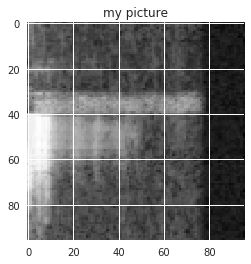

In [43]:
img = cv2.imread("/home/rainbowww5/TFpiscine/voiceRec/input/picts/test/clip_fa39e286a.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.title('my picture')
plt.show()

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


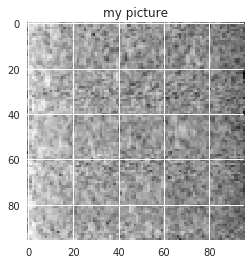

In [44]:
img = cv2.imread("/home/rainbowww5/TFpiscine/voiceRec/input/picts/test/clip_431a9a3a1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.title('my picture')
plt.show()

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


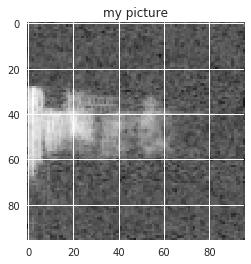

In [45]:
img = cv2.imread("/home/rainbowww5/TFpiscine/voiceRec/input/picts/test/clip_94e4b598d.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.title('my picture')
plt.show()

In [56]:
classifier = tf.estimator.Estimator(
    model_fn=model_fn,
    model_dir="./all_model",
    params=params
    )

In [57]:
def my_test_input_fn(features, batch_size=1, shuffle=True, num_epochs=None):
    raw_features = features
    ds = Dataset.from_tensor_slices((raw_features))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features = ds.make_one_shot_iterator().get_next()
    return features

predict_test_input_fn = lambda: my_test_input_fn(
    test_images,
    num_epochs=1,
    shuffle=False)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])
print(test_predictions)

NotFoundError: Key MobilenetV1/Conv2d_0/BatchNorm/beta not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/home/rainbowww5/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rainbowww5/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-2a9ff81d910d>", line 16, in <module>
    test_predictions = np.array([item['classes'] for item in test_predictions])
  File "<ipython-input-57-2a9ff81d910d>", line 16, in <listcomp>
    test_predictions = np.array([item['classes'] for item in test_predictions])
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 507, in predict
    hooks=all_hooks) as mon_sess:
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 816, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 539, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 1002, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 1007, in _create_session
    return self._sess_creator.create_session()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 696, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 458, in create_session
    self._scaffold.finalize()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py", line 212, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 910, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 829, in _build_internal
    restore_sequentially, reshape)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 525, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key MobilenetV1/Conv2d_0/BatchNorm/beta not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [ ]:
my_submission = pd.DataFrame({'fname': fnames, 'label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_voice_tpu.csv', index=False)

In [35]:
#trainsform csv files into tfrecords
'''
python jpeg_to_tf_record.py \
       --train_csv yes_no_data/train_set.csv \
       --validation_csv yes_no_data/eval_set.csv \
       --labels_file yes_no_data/labels.txt \
       --project_id tensor-flow-piscine \
       --output_dir yes_no_data/output
       
python tpu/models/official/mobilenet/mobilenet.py \
    --alsologtostderr \
    --master=$TPU_WORKER \
    --data_dir=gs://hurrylearn/yes_no_data/output \
    --model_dir=gs://hurrylearn/yes_no_data/model_output \
    --num_shards=8 \
    --batch_size=1024 \
    --use_tpu=1
''''''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-35-67dc09d8000f>, line 18)

In [ ]:
dataframe = pd.read_csv("./train_digit.csv",sep=",")